## Objective: Image Classification using Neural Networks with one hidden layer in PyTorch

### About the dataset: Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples with classes as 0: T-shirt/top, 1: Trouser, 2: Pullover, 3: Dress, 4: Coat, 5: Sandal, 6: Shirt, 7: Sneaker, 8: Bag, 9: Ankle boot

### Reference: https://jovian.com/learn/deep-learning-with-pytorch-zero-to-gans/lesson/lesson-3-training-deep-neural-networks-on-a-gpu?notebook=aakashns/fashion-feedforward-minimal

In [1]:
# Imports
import torch
import torchvision
import numpy as np

In [2]:
# Download dataset
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor

dataset = FashionMNIST(root = 'data/', 
                download = True, 
                transform = ToTensor())

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
from torch.utils.data import random_split

val_size = 10000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [4]:
from torch.utils.data.dataloader import DataLoader

batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, pin_memory=True)

torch.Size([128, 1, 28, 28])


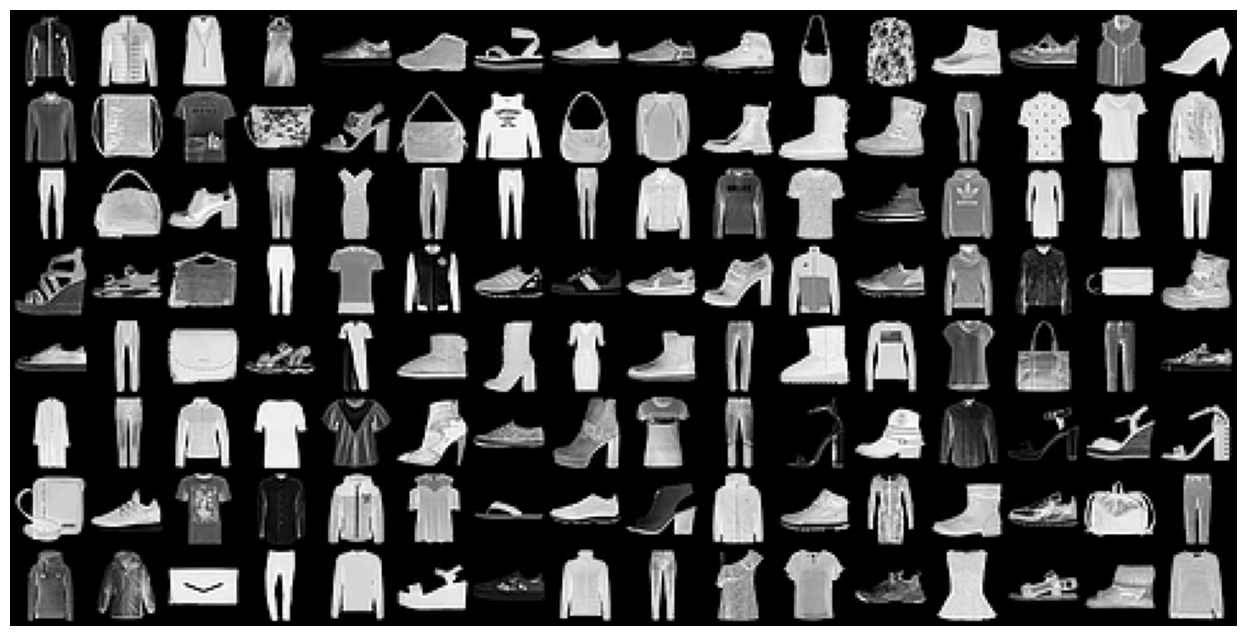

In [5]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

for images,_ in train_loader:
    print(images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute(1,2,0))
    break

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class MnistModel(nn.Module):
    def __init__(self, in_size, out_size, hidden_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
    
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        #xb = xb.view(xb.size(0), -1)
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [7]:
input_size = 784
hidden_size = 32
output_size = 10

model = MnistModel(input_size, output_size, hidden_size)

In [8]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [9]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss)
    break

print('Outputs.shape', outputs.shape)
print('Sample outputs: \n', outputs[:2].data)

Loss: tensor(2.2997, grad_fn=<NllLossBackward0>)
Outputs.shape torch.Size([128, 10])
Sample outputs: 
 tensor([[-0.1551, -0.2048, -0.2236, -0.0365,  0.2937, -0.0847, -0.2701, -0.2032,
         -0.1506, -0.0208],
        [ 0.0124, -0.0344, -0.2060,  0.0445,  0.2488, -0.0510, -0.0797, -0.2485,
         -0.2199, -0.0382]])


In [10]:
torch.cuda.is_available()

True

In [11]:
def get_default_device():
    if torch.cuda.is_available:
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
device

device(type='cuda')

In [12]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cuda:0


In [13]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device =device
    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)

In [14]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

for xb,yb in val_loader:
    print(xb.shape)
    print(xb.device)
    print(yb)
    break

torch.Size([128, 1, 28, 28])
cuda:0
tensor([5, 8, 6, 2, 5, 6, 5, 2, 6, 6, 2, 8, 0, 4, 8, 8, 8, 5, 6, 4, 0, 5, 5, 5,
        7, 8, 3, 3, 7, 1, 8, 8, 0, 5, 1, 5, 1, 4, 6, 6, 5, 6, 3, 7, 4, 2, 8, 6,
        0, 3, 5, 1, 1, 7, 0, 4, 6, 5, 1, 6, 3, 4, 9, 8, 8, 4, 2, 3, 5, 1, 8, 9,
        5, 2, 6, 5, 9, 0, 8, 7, 6, 5, 8, 9, 3, 2, 5, 8, 3, 7, 1, 0, 7, 3, 3, 0,
        9, 3, 4, 6, 5, 3, 1, 5, 3, 9, 0, 3, 8, 4, 1, 5, 2, 1, 4, 5, 7, 1, 3, 4,
        9, 8, 1, 9, 9, 2, 2, 3], device='cuda:0')


In [15]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func= torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [16]:
model = MnistModel(input_size, output_size, hidden_size)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [17]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3156278133392334, 'val_acc': 0.08109176903963089}]

In [18]:
history += fit(10, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.6119, val_acc: 0.7550
Epoch [1], val_loss: 0.5681, val_acc: 0.8037
Epoch [2], val_loss: 0.5151, val_acc: 0.8170
Epoch [3], val_loss: 0.4488, val_acc: 0.8373
Epoch [4], val_loss: 0.3994, val_acc: 0.8608
Epoch [5], val_loss: 0.5192, val_acc: 0.8231
Epoch [6], val_loss: 0.4317, val_acc: 0.8426
Epoch [7], val_loss: 0.4377, val_acc: 0.8403
Epoch [8], val_loss: 0.4625, val_acc: 0.8376
Epoch [9], val_loss: 0.4731, val_acc: 0.8357


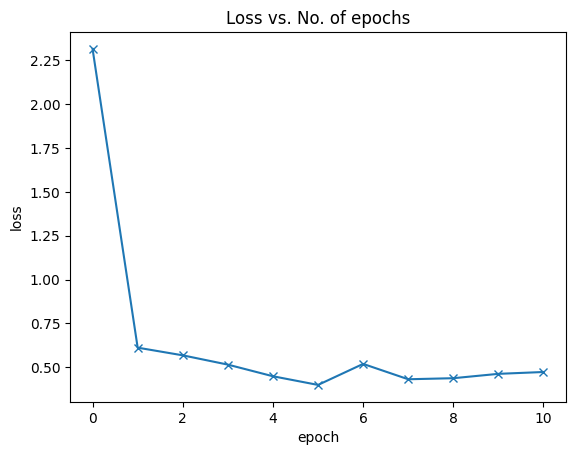

In [19]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

Text(0, 0.5, 'accuracy')

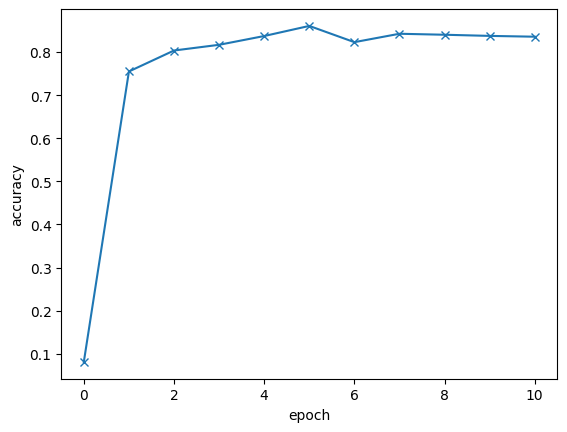

In [20]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
#plt.title('Accuracy vs. No. of epochs');

In [21]:
test_dataset = FashionMNIST(root='data/', 
                     train=False,
                     transform=ToTensor())

In [22]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.4881989657878876, 'val_acc': 0.826855480670929}